In [1]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import numpy as np

Using TensorFlow backend.


# vgg16
from keras.applications.vgg16 import VGG16

vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)

In [2]:
from keras.applications.vgg16 import VGG16

In [7]:
# save vgg16's bottleneck features
def save_bottlebeck_features(train_data_dir = 'data_food/train',
                             validation_data_dir = 'data_food/validation',
                             nb_train_samples = 500*2,
                             nb_validation_samples = 70*2):
    
    img_width, img_height = 150,150
    batch_size = 32
    
    
    datagen = ImageDataGenerator(rescale=1. / 255)
    # build the VGG16 network
    model = VGG16(include_top=False, weights='imagenet')

    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_train = model.predict_generator(
        generator, nb_train_samples // batch_size+1)
    np.save(open(train_data_dir+'/bottleneck_features_train.npy', 'wb'),
            bottleneck_features_train)

    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_validation = model.predict_generator(
        generator, nb_validation_samples // batch_size+1)
    np.save(open(validation_data_dir+'/bottleneck_features_validation.npy', 'wb'),
            bottleneck_features_validation)

In [25]:
# train top model
def train_top_model(nb_train_samples = 1000,
                    nb_validation_samples = 140,
                    epochs = 50,
                    batch_size = 32,
                    top_model_weights_path = 'data_dogncat/bottleneck_fc_model.h5'):
    
    
    train_data = np.load(open('data_food/train/bottleneck_features_train.npy','rb'))
    train_labels = np.array(
        [0] * int(nb_train_samples / 2) + [1] * int(nb_train_samples / 2))

    validation_data = np.load(open('data_food/validation/bottleneck_features_validation.npy','rb'))
    validation_labels = np.array(
        [0] * int(nb_validation_samples / 2) + [1] * int(nb_validation_samples / 2))

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy', metrics=['accuracy'])

    model.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels))
    model.save_weights(top_model_weights_path)
    return model

In [8]:
save_bottlebeck_features()

Found 1000 images belonging to 2 classes.
Found 140 images belonging to 2 classes.


In [26]:
top_model = train_top_model()

Train on 1000 samples, validate on 140 samples
Epoch 1/50
1000/1000 [==============================] - 0s 410us/step - loss: 0.7617 - acc: 0.6910 - val_loss: 0.3340 - val_acc: 0.8714
Epoch 2/50
1000/1000 [==============================] - 0s 246us/step - loss: 0.2537 - acc: 0.9060 - val_loss: 0.2790 - val_acc: 0.8857
Epoch 3/50
1000/1000 [==============================] - 0s 245us/step - loss: 0.1785 - acc: 0.9430 - val_loss: 0.2749 - val_acc: 0.9143
Epoch 4/50
1000/1000 [==============================] - 0s 246us/step - loss: 0.1234 - acc: 0.9600 - val_loss: 0.2323 - val_acc: 0.9000
Epoch 5/50
1000/1000 [==============================] - 0s 253us/step - loss: 0.0914 - acc: 0.9740 - val_loss: 0.2565 - val_acc: 0.9000
Epoch 6/50
1000/1000 [==============================] - 0s 251us/step - loss: 0.0737 - acc: 0.9810 - val_loss: 0.2461 - val_acc: 0.9071
Epoch 7/50
1000/1000 [==============================] - 0s 249us/step - loss: 0.0711 - acc: 0.9770 - val_loss: 0.2909 - val_acc: 0.8714
E

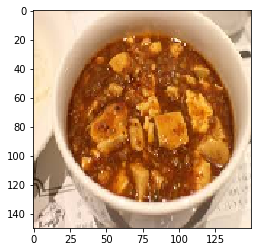

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
path_to_img = 'data_food/train/1mpdf/mpdf045.jpg'
img = load_img(path_to_img,target_size=(150,150))
plt.imshow(img)
img = img_to_array(img)
img = np.expand_dims(img,axis=0)

In [13]:
tester = Sequential()
tester.add(VGG16(input_shape=(150,150,3),weights='imagenet',include_top=False))
tester.add(top_model)
tester.predict(img)

array([[ 0.]], dtype=float32)

In [14]:
def test_food(img_path,model):
    img = load_img(img_path,target_size=(150,150))
    img = img_to_array(img)
    img = np.expand_dims(img,axis=0)
    preds = model.predict(img)
    return preds

In [17]:
impath = 'data_food/test/t-ssbc001.jpg'
test_food(impath,tester)

array([[ 1.]], dtype=float32)

In [20]:
img_gen = ImageDataGenerator()
generator = img_gen.flow_from_directory(
        'data_food/test',
        target_size=(150,150),
        batch_size=1,
        class_mode=None,
        shuffle=False)
predss = tester.predict_generator(generator, 2)

Found 2 images belonging to 2 classes.


In [22]:
print(predss)

[[ 0.]
 [ 1.]]
